# 大模型RAG

一、 RAG的由来 **

二、RAG示例 **

三、 RAG在大模型优化的位置 *

四、RAG各组件优化方案 ***

五、RAG 的优缺点 ***

六、RAG系统常见的问题以及解决方案 *

七、大模型RAT*

八、扩展学习*

## 一、RAG的由来

### LLM的缺陷

1. **LLM存在幻觉现象**
   
<img src="images/LLM Hallucination.png" style="margin-left: 0px" width="600px">



2. **LLM知识更新缓慢**

<img src="images/ChatGPT-Gemini-2.png" style="margin-left: 0px" width="600px">

<img src="images/ChatGPT-Gemini-1.png" style="margin-left: 0px" width="600px">

3.**LLM的回答缺乏透明度/可解释性**

视觉模型的可解释性

<img src="images/CAM.png"  width="500" height="400" alt="区别"/><br>

RAG的可解释性

<img src="images/解释性.png"  width="900" height="400" alt="区别"/><br>

4.**LLM对领域知识的理解有限**

在一些较为浅显的领域，大型语言模型可能通过之前的大量训练数据获得了相应的能力。但当涉及到更深层次的专业领域时，这些模型往往会出现所谓的“幻觉”问题，即生成的信息可能偏离事实或专业知识的真实性

<img src="images/医学1.png"  width="600" alt="区别"/><br>

<img src="images/医学2.png"  width="550" alt="区别"/><br>

<img src="images/胰腺1.png"  width="800" alt="区别"/><br>
<img src="images/胰腺2.png"  width="800" alt="区别"/><br>

5.**数据安全**

a. OpenAI遭到多次隐私数据投诉<br>
<img src="images/openai.data.privacy.png"  width="500" height="400" alt="区别"/><br>
OpenAI官方说明链接：https://openai.com/enterprise-privacy

b. 对于企业而言，将自己的业务数据、经营数据、合同文件等机密数据上传到互联网上的大型模型可能会带来以下后果：

- 数据安全风险：这是最直接的后果。机密数据一旦被上传到互联网上，就可能面临被非法访问或盗用的风险。尽管许多云服务和大数据模型提供了安全保护措施，但并非绝对安全，存在被黑客攻击或内部人员泄露的可能性。
- 违反法律法规：许多国家和地区对企业数据的存储和处理有严格的法律法规。如果企业未经授权就将敏感数据上传到互联网，可能违反数据保护法、隐私法等相关法律法规，从而面临法律责任。
- 商业利益受损：机密数据的泄露可能导致商业秘密流失，影响企业的竞争优势，甚至导致直接的经济损失。
- 信誉和品牌影响：数据泄露事件可能损害企业的信誉和品牌形象，尤其是在客户数据保护方面，可能导致客户信任度下降。
- 合规性挑战：对于跨国经营的企业来说，不同国家对数据传输和存储有不同的要求。数据的跨境传输可能面临复杂的合规性挑战。

c. 对于个人而言，将个人的敏感或私密数据上传到互联网上的大型模型，也可能带来一系列后果：

- 隐私泄露风险：个人信息一旦上传到网络，就有被非法获取和滥用的风险。这可能包括身份信息、财务数据、联系方式、甚至个人习惯和偏好等。
- 身份盗用风险：敏感个人数据的泄露可能导致身份盗用。不法分子可以利用这些信息进行诈骗、非法交易等犯罪活动。
- 信誉和社交影响：如果个人的敏感信息被公开，可能会对个人的社会信誉和人际关系造成负面影响。
- 法律风险：在某些情况下，未经授权共享或存储某些类型的数据可能违反法律法规，如侵犯版权、违反数据保护法等。
- 情感和心理压力：担心个人数据的安全性可能给个人带来持续的情感压力和不安。

### RAG的初衷是为了提高大模型事实性、时效性，降低幻觉，用更具专业性的知识来生成回复

## 二、RAG示例

定义调用OpenAI API的类

In [4]:
!pip install faiss-cpu

Looking in indexes: http://mirrors.tencentyun.com/pypi/simple


In [5]:
import os
import requests
import json
import faiss
from dotenv import load_dotenv

load_dotenv("../.env")

True

In [6]:
from functools import lru_cache

class BaseLLM:
    @lru_cache(maxsize=1024)
    def chat(self, text):
        return self._chat(text)
    def _chat(self, text):
        raise NotImplementedError

In [7]:
from openai import OpenAI

class OpenAILLM(BaseLLM):
    def __init__(self):
        self.client = OpenAI(
            api_key=os.getenv("OPENAI_API_KEY"),
            base_url=os.getenv("OPENAI_API_BASE")
        )
        
    def chat(self, text, messages=[], stops=None):
        return self._chat(text, messages, stops)
        
    def _chat(self, text, messages=[], stops=None):
        if not messages:
            messages = [{"role": "user", "content": text}]
        # 为了保证实验和课程的结果一致，这里使用了固定的 engine
        response = self.client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=messages,
            stream=False,
            stop=stops,
        )
        return response.choices[0].message.content

In [8]:
openai_bot = OpenAILLM()

In [9]:
openai_bot.chat("你好")

'你好！有什么可以帮助你的吗？😊'

### 搭建知识库以及向量数据库

In [10]:
!pip install langchain
!pip install openai
!pip install PyPDF2
!pip install faiss-cpu
!pip install tiktoken

Looking in indexes: http://mirrors.tencentyun.com/pypi/simple
Looking in indexes: http://mirrors.tencentyun.com/pypi/simple
Looking in indexes: http://mirrors.tencentyun.com/pypi/simple
Looking in indexes: http://mirrors.tencentyun.com/pypi/simple
Looking in indexes: http://mirrors.tencentyun.com/pypi/simple


In [11]:
from PyPDF2 import PdfReader
from langchain.vectorstores import ElasticVectorSearch, Pinecone, Weaviate, FAISS
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter
import os
from langchain.chains.question_answering import load_qa_chain
from langchain.llms import OpenAI

#### 知识库搭建

在RAG（Retrieval-Augmented Generation）模型中，知识库（Knowledge Base，KB）扮演着至关重要的角色。它是一个由大量文档、文章、事实或其他类型信息组成的集合，RAG模型通过检索知识库中的内容来增强其生成的文本。以下是知识库在RAG中的一些关键特点和作用：
    
**知识库的组成：**

- 知识库可以包含各种类型的数据，如维基百科条目、新闻文章、科学论文、书籍摘录、网页内容等。
- 数据通常以文本形式存储，但也可以包括结构化数据，如图谱、数据库记录等。

**作用与功能：**

- 信息检索：RAG模型使用检索器从知识库中查找与输入查询相关的信息。这些信息用于辅助生成器产生回答或内容。

- 增强内容生成：检索到的文档提供了上下文和背景信息，帮助生成器创建更准确、更丰富的文本。

- 提高准确性和可靠性：对于需要事实支持的查询（如特定的知识性问题），知识库提供了必要的信息源，从而提高回答的准确性和可靠性。

**知识库的构建与维护：**

- 知识库的构建可能涉及大量数据的收集、整理和索引。
- 维护知识库可能需要定期更新以保持信息的准确性和时效性。

**挑战：**

- 覆盖面和质量：知识库需要包含广泛的话题和高质量的内容，以支持多样化的查询。

- 更新与维护：随着时间的推移，知识库需要更新和维护，以反映最新的信息和数据。

总之，知识库在RAG模型中起着至关重要的作用，它为模型提供了必要的信息和数据支持，使模型能够生成更准确、更相关、更丰富的内容。知识库的质量和维护直接影响到RAG模型的效果和效能。

#### 数据清洗与标注
通常认为可以存进知识库的数据，应属于质量较高的数据，通常是由可信机构出版的书籍、报告、知识网页等内容，也可以根据应用需求加入一些权威媒体的最新报道，在以上形式的内容转换为向量数据库可以接受的数据前，可能需要进行一定程度的清洗、过滤、标注等。此部分内容将在大模型微调一课中学习，下面节选部分进行回顾，可以在实践过程中参考实施。

**质量过滤**

确保训练语料库只包含高质量数据的两种主要方法：**基于分类器的方法和基于启发式的方法**。

基于分类器的方法训练一个二元分类器来识别和过滤低质量数据，以高质量文本（例如，维基百科页面）作为正例，候选数据作为负例。

然而，基于分类器的方法可能无意中移除了方言、口语和社会方言等高质量文本，导致偏见和语料库多样性的减少。

相比之下，有些**启发式的方法采用精心设计的规则**来排除低质量文本。

这些规则包括基于语言的过滤、基于度量的过滤、基于统计的过滤和基于关键字的过滤。

基于语言的过滤删除与LLM任务无关的语言文本，而基于度量的过滤使用评估度量，如困惑度来检测不自然的句子。

基于统计的过滤根据语料库的统计特征来衡量文本质量，而基于关键字的过滤则根据特定的关键字集（如HTML标签、超链接、样板文本和冒犯性词汇）来移除噪声或无用元素。

**去重复**

以往的研究表明，在预训练语料库中存在**重复数据会减少语言模型的多样性**，可能导致训练过程中的不稳定，并对模型的性能产生负面影响。

因此，去重复是必要的，以从语料库中移除重复实例。这可以在不同的层面上进行，包括句子级、文档级和数据集级。

在句子级别，包含重复短语或词汇的低质量句子应该被移除，以避免将重复模式引入模型中。

在文档级别，先前的研究依赖于表面特征重叠（例如，词汇和n-gram）来识别和移除具有相似内容的重复文档。

此外，为了防止训练集和评估集之间的污染，重要的是要从训练集中移除可能的重复文本。


下面是一个面对纯文本的例子

<img src="images/vector-search.svg"  width="1000" alt="RAG同其他大模型优化方法对比"/>

In [12]:
knowledge_list = [
    "剑桥大学的校长是马冬梅，马教授是一名计算机专业的教授，她的主要研究方向是自然语言处理",
    "牛津大学的软件学院院长是李磊，李教授是一名计算机专业的教授，他的主要研究方向是机器学习",
    "hit 有五万名学生",
    "wit 有三万名学生",
    "huts 的医学院是中部地区最好的医学院，最擅长临床医学的研究",
]

# 创建一个1536维的FAISS向量数据库，使用L2距离进行相似性搜索
hit_vd = faiss.IndexFlatL2(1536)

接下来我们将使用一个简单的向量数据库来实现检索增强，这在模型没有训练过的场景上非常有效。

#### 知识库向量化

知识的增强检索需要通过embedding模型进行向量化并存储在向量知识库中，下面这个代码使用openai的模型生成对应的embedding作为例子

In [13]:
!pip install langchain_community -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [14]:
# embedding_function = SentenceTransformerEmbeddings(model_name='/home/courseteam/models/models/Yinka')

In [15]:
import numpy as np
# 先使用 openai 的模型生成对应的 embedding
@lru_cache(maxsize=1024)
def get_embedding(texts: tuple, model="text-embedding-ada-002"):
    texts = list(texts)
    if isinstance(texts, str):
        texts = [texts]
    response = openai_bot.client.embeddings.create(
        input=texts,
        model=model,
    )
    # 使用指定的 model 对 texts 中的文本进行嵌入向量的生成。
    #openai_bot.client.embeddings.create 函数接收两个参数：input（待处理的文本列表）和 model（用于生成嵌入向量的模型）。
    embs = [e.embedding for e in response.data]
    return embs

# 生成 embedding
embs = get_embedding(tuple(knowledge_list))
# 将 embedding 添加到 faiss 索引中

hit_vd.add(np.array(embs).astype("float32"))

In [16]:
prompt = "请告诉我牛津大学软件学院院长的研究方向是什么？"
query_vector = get_embedding(prompt)[0]

In [18]:
# 接下来我们来观察一下在我们编造的数据上，使用 rag 检索增强方案能够带来怎样的效果提升
distances, indices = hit_vd.search(np.array([query_vector]).astype('float32'), 2)

research_result = [knowledge_list[i] for i in indices.tolist()[0]]
print(f"查询的问题是：{prompt}\n检索到的答案是：{research_result}")

查询的问题是：请告诉我牛津大学软件学院院长的研究方向是什么？
检索到的答案是：['牛津大学的软件学院院长是李磊，李教授是一名计算机专业的教授，他的主要研究方向是机器学习', '剑桥大学的校长是马冬梅，马教授是一名计算机专业的教授，她的主要研究方向是自然语言处理']


In [19]:
print(openai_bot.chat(prompt))

牛津大学软件学院的院长是Prof. Michael Wooldridge。他的研究方向主要包括人工智能、多智能体系统和计算社会科学。他领导了多个研究项目，探讨了诸如机器学习、计算博弈论、和社会网络分析等领域的问题。Prof. Michael Wooldridge在计算机科学领域有着深厚的研究经验和学术声誉。


In [20]:
print(openai_bot.chat(f"从知识库中检索到了相关知识：：{research_result}\n{prompt}"))

牛津大学软件学院院长的研究方向是机器学习。


除去使用openai的模型，也可以在huggingface、modelscope等开源社区平台进行模型下载

modelscope开源社区平台：https://www.modelscope.cn/home

下载模型方式：点击Models，进入模型页面，在搜索框搜索想要下载的模型
<img src="images/modelscope-home.png"  width="1000" alt="quivr"/>
<img src="images/modelscope-models.png"  width="1000" alt="quivr"/>
点击右侧的Download model
<img src="images/modelscope-download.png"  width="1000" alt="quivr"/>
选择指令在终端输入执行，即可进行模型下载
<img src="images/modelscope-clone.png"  width="1000" alt="quivr"/>

huggingface镜像网站：https://hf-mirror.com/ 

下载模型方式：搜索想要下载的模型
<img src="images/hf.png"  width="1000" alt="quivr"/>
在下拉框点击 clone repository 选择指令在终端输入执行，即可进行模型下载
<img src="images/hf-download.png"  width="1000" alt="quivr"/>
<img src="images/hf-clone.png"  width="1000" alt="quivr"/>


#### 向量数据库

在RAG（Retrieval-Augmented Generation）模型中，向量数据库是一个关键组件，用于存储和检索文档的向量表示。这个数据库的主要功能是支持检索过程，其中模型根据与用户查询相似的文档向量，高效地查找相关信息。以下是向量数据库在RAG模型中的一些主要特点和作用：

**向量化的文档：**

- 在RAG模型中，文档（如网页、新闻文章、书籍章节等）首先被转换成向量形式。这通常通过预训练的自然语言处理（NLP）模型（如BERT、GPT等）完成，这些模型能够将文本转换为固定长度的数值向量。

**数据库构建：**

- 这些向量被存储在一个专门的数据库中，称为向量数据库。这个数据库可以是内存中的简单结构，也可以是更复杂的、针对大规模数据集优化的存储系统。

**高效检索：**

- 向量数据库允许模型快速查询与输入问题语义上最接近的文档向量。这通常通过计算向量之间的相似度（如使用余弦相似度或欧几里得距离）来实现。

**技术实现：**

- 实现向量数据库的常见技术包括使用FAISS（Facebook AI Similarity Search）等高效的相似性搜索库。这些技术特别适用于高维空间中的近似最近邻搜索。

**挑战：**

- 向量数据库需要高效地处理和索引大量数据，同时保持查询的快速响应。
- 确保向量的质量和表示的准确性对于检索的相关性和准确性至关重要。

<div class="alert alert-success">
总之，向量数据库在RAG模型中扮演着重要角色，它使得模型能够快速、高效地检索与用户查询相关的文档，从而帮助生成模型产生更准确、更相关的回答。向量数据库的优化和管理是实现高性能RAG模型的关键因素之一。
</div>

In [21]:
docsearch = FAISS.from_texts(knowledge_list, OpenAIEmbeddings())

/home/ubuntu/anaconda3/envs/notebook/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


In [23]:
# openai_model = OpenAI(
#     api_key=os.getenv("OPENAI_API_KEY"),
#     base_url=os.getenv("OPENAI_API_BASE"),
#     model="gpt-3.5-turbo-0613",
# )

In [24]:
query = "什么是Latent Consistency Models，他适用于什么方面的任务，请用中文简短回答"

In [25]:
docs = docsearch.similarity_search(query)
relvants = ""
for i in range(len(docs)):
    relvants += docs[i].page_content

In [19]:
print(relvants)

牛津大学的软件学院院长是李磊，李教授是一名计算机专业的教授，他的主要研究方向是机器学习剑桥大学的校长是马冬梅，马教授是一名计算机专业的教授，她的主要研究方向是自然语言处理huts 的医学院是中部地区最好的医学院，最擅长临床医学的研究hit 有五万名学生


In [20]:
print(openai_bot.chat(query))

潜在一致性模型是一种用于处理具有不确定关系的数据集的机器学习模型。它适用于需要从数据中推断出隐含规律或者概念的任务领域。


In [136]:
print(openai_bot.chat(relvants + "/n" +query))

潜在一致性模型是一种用于处理数据中潜在依赖关系的模型。它适用于任务包括建模多个相关数据源之间的一致性、处理缺失数据、改进推荐系统等方面。


#### 对于大文档的处理方式：文档切割

在RAG（Retrieval-Augmented Generation）模型中，文档切割（Document Splitting）是处理大型文档以便于检索和生成的一种关键技术。RAG模型首先检索与查询相关的信息，然后基于这些信息生成回答。对于大型文档，直接处理整个文档可能不实际或效率低下，这就是文档切割变得重要的地方。

<div class="alert alert-success">
以下是文档切割的主要方面和作用：
</div>

**文档切割的目的：**

- 将大型文档分割成更小、更易于管理的段落或部分。
- 使得检索系统能够更高效地找到与用户查询最相关的文档段落。
- 减少在生成回答时需要考虑的信息量，提高生成过程的效率和质量。

**实现方法：**

- 文档可以基于各种标准进行切割，如固定长度的窗口、自然段落边界或特定的语义标记。
- 自动化的文本处理技术，如自然语言处理（NLP）算法，可以用来识别合适的切割点。

**挑战：**

- 切割策略的选择对于确保信息的完整性和相关性非常重要。不恰当的切割可能导致上下文信息的丢失。
- 在保持文档原有意义的同时进行有效切割需要精确和先进的NLP技术。

**优点：**

- 通过仅检索和处理与查询最相关的文档部分，可以显著提高效率和响应速度。
- 切割后的文档更容易被模型处理，有助于提高回答的准确性和相关性。

总之，文档切割在RAG模型中是处理和检索大型文档的一种有效方法，它可以提高检索的精确性和生成过程的效率。通过合理的切割策略，可以确保在回答用户查询时同时保持信息的完整性和相关性。

In [26]:
# 导入PdfReader类用于读取PDF文件
loader = PdfReader("files/2311.05556.pdf")  # 加载指定路径的PDF文件
result = ''  # 初始化一个空字符串，用于存储提取的文本
# 遍历PDF文件中的每一页
for i, page in enumerate(loader.pages):
    text = page.extract_text()  # 从当前页提取文本
    if text:  # 如果当前页提取到了文本
        result += text  # 将提取到的文本添加到结果字符串中

# 此代码段主要用于从PDF文件中提取文本内容，将所有页面的文本合并为一个字符串。


In [27]:
# 定义一个递归字符文本拆分器，用于将文本分割成指定大小的块
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=512,  # 设定每个文本块的字符数
    chunk_overlap=32,  # 设定文本块之间的重叠字符数
    length_function=len,  # 使用len函数来计算文本长度
)
texts = text_splitter.split_text(result)  # 使用拆分器将提取的文本分割成多个部分

# 这段代码创建了一个文本拆分器，它可以将一个较长的文本递归地分割成多个小块，每个小块包含指定数量的字符。
# 分割时，相邻的文本块会有一定数量的字符重叠，这有助于处理那些可能被拆分在两个块中间的词汇或信息。
# 这个过程在处理需要分块处理的大文本数据时非常有用，比如在自然语言处理任务中预处理数据以适配模型的输入限制。

In [28]:
print(texts[0])

Technical Report
LCM-L ORA: A U NIVERSAL STABLE -DIFFUSION
ACCELERATION MODULE
Simian Luo∗,1Yiqin Tan∗,1Suraj Patil†,2Daniel Gu†Patrick von Platen2
Apolin ´ario Passos2Longbo Huang1Jian Li1Hang Zhao1
1IIIS, Tsinghua University2Hugging Face
{luosm22, tyq22 }@mails.tsinghua.edu.cn
{suraj, patrick, apolinario }@huggingface.co
{dgu8957 }@gmail.com
{longbohuang, lijian83, hangzhao }@tsinghua.edu.cn
ABSTRACT
Latent Consistency Models (LCMs) (Luo et al., 2023) have achieved impres-


#### 案例介绍：Quivr

Quivr 是一款使用生成 AI 技术来存储和检索非结构化信息的“第二大脑”，可以将其视为 Obsidian 的增强版，并且具备更强的人工智能功能。

Quivr 可以处理几乎所有类型的数据，包括文本、图像、代码片段等。它采用先进的人工智能技术来帮助您生成和检索信息。同时，它还专注于速度和效率，确保您可以快速访问数据。您的数据安全由您掌控，Quivr 支持多个文件格式，包括文本、Markdown、PDF、PowerPoint、Excel、Word、音频、视频等。

其工作流程如下图所示：

<img src="images/quivr.png"  width="1000" alt="quivr"/>

demo演示如下：

https://github.com/StanGirard/quivr/assets/19614572/a6463b73-76c7-4bc0-978d-70562dca71f5

#### 延伸：什么是向量相似度？

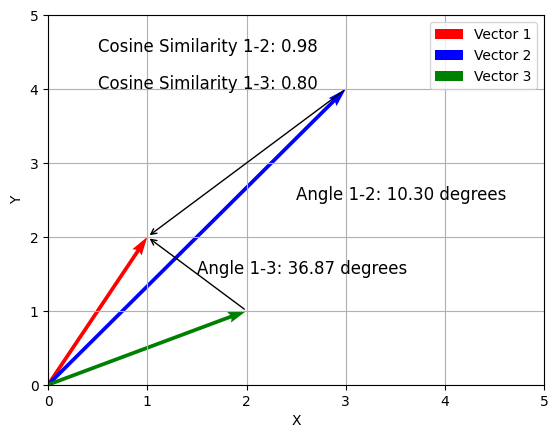

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# 定义两个向量
vector1 = np.array([1, 2])
vector2 = np.array([3, 4])
vector3 = np.array([2, 1])

# 绘制向量
plt.quiver(0, 0, vector1[0], vector1[1], angles='xy', scale_units='xy', scale=1, color='r', label='Vector 1')
plt.quiver(0, 0, vector2[0], vector2[1], angles='xy', scale_units='xy', scale=1, color='b', label='Vector 2')
plt.quiver(0, 0, vector3[0], vector3[1], angles='xy', scale_units='xy', scale=1, color='g', label='Vector 3')

# 设置坐标轴范围和标签
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.xlabel('X')
plt.ylabel('Y')

# 添加图例
plt.legend()

# 绘制v1和v2之间的夹角
angle12 = np.arccos(np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2)))
plt.annotate("", xy=(vector1[0], vector1[1]), xytext=(vector2[0], vector2[1]), arrowprops=dict(arrowstyle="->", lw=1, color='black'))
plt.text(2.5, 2.5, f'Angle 1-2: {np.degrees(angle12):.2f} degrees', fontsize=12)

# 绘制v1和v3之间的夹角
angle13 = np.arccos(np.dot(vector1, vector3) / (np.linalg.norm(vector1) * np.linalg.norm(vector3)))
plt.annotate("", xy=(vector1[0], vector1[1]), xytext=(vector3[0], vector3[1]), arrowprops=dict(arrowstyle="->", lw=1, color='black'))
plt.text(1.5, 1.5, f'Angle 1-3: {np.degrees(angle13):.2f} degrees', fontsize=12)


# 计算余弦相似度
cosine_similarity12 = np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))
cosine_similarity13 = np.dot(vector1, vector3) / (np.linalg.norm(vector1) * np.linalg.norm(vector3))
# 添加余弦相似度文本
plt.text(0.5, 4.5, f'Cosine Similarity 1-2: {cosine_similarity12:.2f}', fontsize=12)
plt.text(0.5, 4, f'Cosine Similarity 1-3: {cosine_similarity13:.2f}', fontsize=12)

# 显示图形
plt.grid()
plt.show()

In [25]:
import numpy as np

def l2_distance(vec1, vec2):
    # 将列表转换为NumPy数组
    vec1 = np.array(vec1)
    vec2 = np.array(vec2)
    return np.linalg.norm(vec1 - vec2)

def cosine_similarity(vec_a, vec_b):
    """
    计算两个向量的余弦相似度。
    :param vec_a: 向量 a
    :param vec_b: 向量 b
    :return: 两个向量之间的余弦相似度
    """
    dot_product = np.dot(vec_a, vec_b)
    norm_a = np.linalg.norm(vec_a)
    norm_b = np.linalg.norm(vec_b)
    return dot_product / (norm_a * norm_b)

# 计算所有嵌入向量之间的余弦相似度
similarity_matrix = np.zeros((len(embs)))

for i in range(len(embs)):
    # similarity_matrix[i] = l2_distance(query_vector, embs[i])
    similarity_matrix[i] = cosine_similarity(query_vector, embs[i])
for i in range(len(similarity_matrix)):
    print(f"问题与知识库内容{i+1}：\"{knowledge_list[i]}\"的相似度为{similarity_matrix[i]}")

问题与知识库内容1："剑桥大学的校长是马冬梅，马教授是一名计算机专业的教授，她的主要研究方向是自然语言处理"的相似度为0.7625088004445055
问题与知识库内容2："牛津大学的软件学院院长是李磊，李教授是一名计算机专业的教授，他的主要研究方向是机器学习"的相似度为0.7657167819574947
问题与知识库内容3："hit 有五万名学生"的相似度为0.7519682731772714
问题与知识库内容4："wit 有三万名学生"的相似度为0.7584104668839892
问题与知识库内容5："huts 的医学院是中部地区最好的医学院，最擅长临床医学的研究"的相似度为0.7450654767132705


<div class="alert alert-warning">

#### 延伸：什么是embedding?
</div>
embedding 是指将客观世界中离散的物体或对象（如单词、短语、图片）等映射到特征空间的操作，embedding向量是指映射后 的特征空间中连续且稠密的高维向量。在机器学习场景中，我们经常使用embedding向量 来描述客观世界的物体。embedding向量 不是对物体进行简单编号的结果，而是在尽量保持相似不变性的前提下 对物体进行特征抽象和编码的产物。通过不断训练，我们能够将客观世界中的物体不失真的映射到高维特征空间中，进而可以使用这些embedding向量 实现分类、回归和预测等操作。

Embedding 就是用一个数值向量“表示”一个对象（Object）的方法。“实体对象”可以是image、word等，“数值化表示”就是一个编码向量。例如对“颜色“这种实体对象用（R，G，B）这样一个三元素向量编码。embedding还可以理解成将离散目标投影到连续空间中的某个点上。数值化的embedding vector本身是没有意义的，不同vector之间的相对关系才是有实际意义的。例如：NLP中最基本的word embedding，给每一个单词一个N维编码向量（或者说将每个word投影到N维空间中），我们期望这种编码满足这样的特性：两个向量之间的”距离“越小，代表这两个单词含义越接近。比如利用 Word2vec 这个模型把单词映射到了高维空间中，从 king 到 queen 的向量和从 man 到 woman 的向量，无论从方向还是尺度来说它们都异常接近。

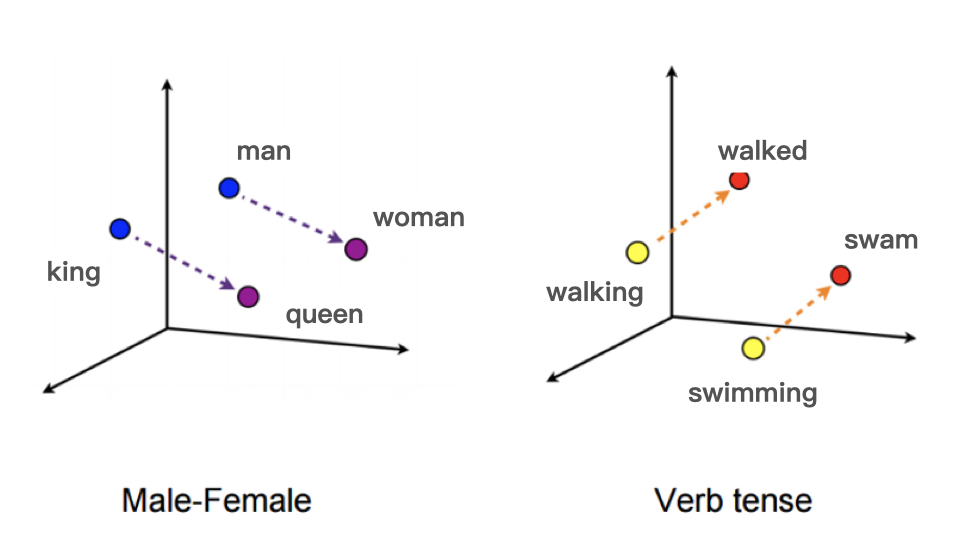

计算的基础是数，而自然语言是文字，因此很容易想到要做的第一步是让文字数字化，为行文方便，我们将这个过程叫做编码。要设计编码的方法，自然需要思考的问题是：哪些性质是编码规则必须要满足的？

1.每一个词具有唯一量化值，不同词需要具有不同的量化值；

2.词义相近词需要有”相近”的量化值；词义不相近的词量化值需要尽量“远离”。当这条性质得到满足时，同义的句子在序列特征上会更加接近，这将有利于计算机而言更高效地理解共性、区分特性；反之则会给计算机制造非常多的困难。**难以捕捉同质内容之间的共性，就意味着模型需要更多的参数才能描述同等的信息量，学习的过程显然困难也会更大。**

3.词义的多维性。对于每一个词，我们可以表达为一组数，而非一个数；这样一来，就可以在不同的维度上定义远近，词与词之间复杂的关系便能在这一高维的空间中得到表达。

图像可以有embedding，句子和段落也可以有 embedding —— 本质都是通过一组数来表达意义。段落的 embedding 可以作为基于语义搜索的高效索引，AI 绘画技术的背后，有着这两种 embedding 的互动 —— 未来如果有一个大一统的多模态模型，embedding 必然是其中的基石和桥梁 。

## 三、RAG在大模型优化的位置

在面对具有不同需求的任务时，我们可能会采用不同的技术解决相关问题：

<img src="images/RAG同其他大模型优化方法对比.png"  width="800" alt="RAG同其他大模型优化方法对比"/>

下面是RAG的几种典型架构：

<img src="images/rag.paradigms.png"  width="900" alt="RAG范例"/>

**传统RAG**

- 用户发出查询后，系统对一个文档集合进行索引，然后执行检索操作。
- 检索到的信息被用来提示（Prompt）一个大型语言模型（Frozen LLM），该模型生成输出结果。
- 这种方法直接利用检索到的信息来生成回答，但不包括预检索或后检索处理。

**进阶RAG**

- 在预检索阶段，可能包括查询路由、查询改写和查询扩展等步骤，以优化检索效果。
- 在检索阶段，系统从文档集合中检索信息。
- 后检索处理可能包括重新排名（Rerank）、摘要（Summary）和融合（Fusion）等步骤，这些都是在提示冻结的LLM之前对检索结果的额外处理。
- 最后，由LLM生成最终输出。
- 此架构通过预检索和后检索优化，提高了检索的准确性和生成的质量。

**模块化RAG**

- Modular RAG是一个模块化的架构，由不同的组件组成，如Routing（路由）、Search（搜索）、Predict（预测）、Retrieve（检索）、Read（阅读）和Fusion（融合）。
- 每个模块独立工作，但同时与其他模块交互，以优化整体性能。
- 它还包括一个模块交互的内存模块，这可能用于存储检索结果或中间状态，以便不同模块可以共享信息。
- 在模式部分，图展示了不同模块如何结合来实现特定的任务，如改写查询、检索信息、生成回答等。
- Modular RAG的设计允许灵活地添加、更新或替换模块，使得系统能够适应不断变化的需求和最新的技术进展。

模块化RAG不是独立存在的。高级RAG是模块化RAG的一种特殊形式，进一步来说，简单RAG本身就是高级RAG的一个特例。这三种范式之间的关系是继承和发展的关系。

## 四、RAG各组件优化方案

<img src="images/rag component.png"  width="1200" alt="区别"/>

### OPENAI的RAG策略
在OPENAI的内部会议中，做过一个名为《A Survey of Techniques for Maximizing LLM Performance》的报告，对于如何通过RAG的方式使用大模型获得良好表现进行了论述。任务的背景是客户有一个大模型和两个独立的知识库，大模型需要识别用户问题需要在哪个知识库中检索相应的知识。当仅使用余弦相似度检索时，在测试任务上达到了45%的基线准确率。后续通过3阶段8种尝试，使RAG的准确率从45%提升到98%。方法具体如下：

<div class="alert alert-success">
    
#### 第一阶段
尝试1：
使用HyDE检索（hypothetical document embedding retrieval）替代语义相似度检索，模型先给出一个“假”的回答，然后用“假”的回答去检索知识库，看是否有知识返回。这种方案在有些场景上表现良好，但在另一些场景上表现不足。

尝试2：

微调 embedding 模型，通过模型训练改变向量的空间分布。它从准确率提升的角度看是有效的，但需要进行训练与纯使用RAG有冲突。

尝试3：

尝试不同的文本块(chunk)长度，并且切块后重新进行embedding，从而帮助模型识别到更加相关的内容。这个过程大概重复了20次，然后准确率从45%上升至了65%。
</div>

<div class="alert alert-success">

#### 第二阶段

尝试4：

使用一个 Cross-Encoder 模型帮助对结果进行排序。Cross-Encoder主要用于文本匹配和相似度分析，在问答系统中可以判断一个给定的问题和一系列可能的答案之间的匹配程度。并且在排序的基础上增加了一部分规则，例如，选择召回文档中日期最为接近的那一篇作为上下文。这个方案对结果的提升帮助很大。

尝试5：

因为用户场景中有两个知识库，因此在这里采用了一个分类模型，收到请求后，会由分类模型先判断请求应该检索哪个知识库。

能过4和5两种尝试，准确率从65%提升到85%。
</div>

<div class="alert alert-success">

#### 第三阶段

尝试6：

进行Prompt Engineering，调整了问问题的方式。

尝试7：

更进一步地分析 badcase，查看 badcase 中出错的类别，并针对这些错误针对性地引入了工具。例如当模型需要从文档中提取数字时表现不佳，OpenAl将数字存入到了数据库数据表中，并通过执行SQL语句来完成最终的数值提取和计算。

尝试8：

问题拆分。例如一个人一口气问了3个问题，则将这3个问题拆成3个独立的问题，分别使用 RAG 进行检索及回答后，再对答案进行拼接，统一作为答案返回给用户。

通过以上8种尝试，将回答准确率由85%提升至98%。</div>



## 五、RAG 的优缺点

<img src="images/rag-vs-finetuning-chn.png"  width="600" height="600" alt="rag-vs-finetuning-chn"/>

#### RAG的优点：
- 知识性回答：RAG擅长提供具体、详细的信息，例如特定公司的岗位或某疾病的症状。这得益于其结合了检索和生成的机制，能够从大量数据中提取具体信息。
- 内容性描述：在解答涉及特定内容的问题时，如某个主题的特点或属性，RAG能够有效地提供准确的描述和信息。
- 描述性回答：对于需要详细描述或解释的问题，RAG能够提供丰富、具体的回答，帮助理解和解释复杂的概念。
#### RAG的缺点：
- 时间/空间跨度大的回答：对于涉及长时间跨度或广泛空间范围的问题，例如公司历史变更或软件版本升级历程，RAG可能难以提供全面或准确的总结。
- 大规模文档总结：对于需要从大量页面或文档中提取并总结信息的任务，如对一本100页书籍的内容总结，RAG可能不太擅长，因为这需要对大量信息进行综合和筛选。
- 复杂推理：在需要进行深层次逻辑推理或找到复杂关系链条的任务中，如从实体A到实体B的推理路径，RAG可能表现不佳。
总的来说，RAG模型在处理具体、知识性的问题时表现出色，但在处理需要广泛文档阅读、复杂推理或总结大量信息的任务时可能会有局限性。

## 六、RAG系统常见的问题以及解决方案

### 常见问题

<div class="alert alert-success">
    
1. 模型生成阶段没有检索到输入相关的信息<br>
* 知识库不存在输入相关信息<br>
</div>

<div class="alert alert-success">

2. 模型生成的答案不完整<br>
* 检索到的而信息不完整（切分方案不够好）<br>
* 模型生成遗漏（问题比较发散时，容易触发此类问题）<br>
</div>

<div class="alert alert-success">

3. 模型的事实性错误（幻觉）<br>
* 模型在生成部分内容时，脱离了外部知识片段<br>
* 对细节不敏感，对检索到的外部知识有理解偏差（检索是基于相似性或相关性，生成内容时也是先把prompt和外部知识编码）<br>
</div>

<div class="alert alert-success">

4. RAG过于依赖相似度的问题<br>
* 基于相似度的检索方法可能会回答问题时缺乏关键信息，例如在查询“告诉我关于作者George RR Martin”的信息时，相似度高的文档却可能提供较少的有用信息。<br>
* 面对多个检索文档的处理，目前方法可能无法很好地提炼共同点和特征，导致信息损失和性能下降。<br>
</div>

### 解决方案

1.用户输入优化

**A. 改写Query**   

好处是一方面可以提升系统对用户输入的鲁棒性，另一方面可以提高系统的召回率

**B. Query分解**

1）将一个多跳/复杂问题拆解为若干个独立问题；<br>
2）然后逐步检索每个子问题相关的信息来回答单个问题；<br>
3）将单个问题的回复综合起来生成原始Query的回复。<br>
<img src="images/hotpot_qa_compare.jpg"  width="500" height="400" alt="区别"/>

图片来源：https://github.com/khaimt/qa_expert/tree/main?tab=readme-ov-file
<!-- QA Expert: LLM for Multi-hop Question Answering -->
<!-- https://github.com/khaimt/qa_expert/tree/main?tab=readme-ov-file -->

<div class="alert alert-warning">

**示例1:**
**query**:广东的省会有哪些旅游景点？<br>
</div>
**retrieve**（“广东的省会是什么？”）  检索结果：广东的省会是广州市，这是一个历史悠久且现代化的大都市。<br>
**retrieve**（“广州有哪些旅游景点？”）<br>
检索结果：广州的热门旅游景点包括：<br>
珠江夜游，可以欣赏广州的夜景。<br>
白云山，提供城市美景和自然风光。<br>
广州塔（小蛮腰），是广州的标志性建筑。<br>
上下九步行街，热门的购物和美食地点。<br>
沙面，展示殖民时期的建筑风格。<br>
陈家祠，一个展示精美岭南建筑的地方。<br>
中山纪念堂，纪念孙中山先生。<br>
荔枝湾涌，体验传统的岭南水乡景致。<br>
**response**：广东省会广州的一些旅游景点包括珠江夜游、白云山、广州塔、上下九步行街、沙面、陈家祠、中山纪念堂和荔枝湾涌等。这些景点展示了广州的历史、文化、自然美景和现代化面貌。

<div class="alert alert-warning">

**示例2:**
**query**:深圳和新加坡的人口相比如何？<br>
</div>

**retrieve**（“深圳的人口是多少？”）<br>
检索结果：深圳是一个快速发展的大都市，在最近的数据中，深圳的人口数量约为1200万至1500万之间，具体数字可能会因不同数据源而有所不同。<br>
**retrieve**（“新加坡的人口是多少？”）<br>
检索结果：新加坡是一个城市国家，其人口数量较小，根据最新数据，新加坡的人口大约在560万至600万之间。<br>
**response**：<br>
深圳和新加坡的人口相比，深圳的人口数量显著多于新加坡。深圳作为一个人口密集的大都市，人口数量大约是新加坡的两倍多。这反映了两个城市不同的地理、经济和社会特征。

**C 利用大模型知识提高检索召回精度**<br>
HyDE (Hypothetical Document Embeddings)<br>
<img src="images/hyde.png"  width="600" height="600" alt="区别"/>

[论文：Precise Zero-Shot Dense Retrieval without Relevance Labels](https://aclanthology.org/2023.acl-long.99.pdf)



**Existing Methods:**
$$ sim(q,d)=<enc_q(q),enc(d)>=<v_q,v_d>$$

**Problem:**<br>
**零样本学习和编码相关性困难**<br>
尤其是在垂直、小众、特定领域，query和doc在 Embedding模型的训练阶段没有出现过，它们的Embedding表示也就很难准确表达对应的语义，其相似性计算结果可信度就不高。<br>

**Solution:**<br>
1）零样本提示下生成假设文档（该假设文档可以学习编码相关模式，这个模式是fake的，所以可能存在幻觉）；<br>
2）使用无监督对比学习编码器将文档编码成Embedding，同时编码器的密集瓶颈可以过滤掉文档中的幻觉，有助于通过相似计算检索到真实文档；<br>
3）基于query和HyDE进行检索，获取更高召回精度的目标文档。

**Methods:**<br>
1）大模型生成query相关的HyD。这些HyD虽然是fake的，但来源于真实的Doc<br>
$$g(q,Inst)=InstructLM(q,Inst)$$

<img src="images/hyde_example.png"  width="600" height="600" alt="区别"/>

2）将HyD传入Contrastive Encoder （论文使用的是Contriever）,将其映射为一个稠密向量$f(\hat{d}_k)$。这里的编码器起到滤波作用，用于过来fake文档的噪声。<br>

3）通过生成多个HyD和原始的query进行平均得到更适应当前大模型新query表示。
$$\hat{v}_{ij} = \frac{1}{N + 1} \left[ \sum_{k=1}^{N} f(\hat{d}_k) + f(q_{ij}) \right]$$

**带着query和候选答案去检索，大概率能找到与query和候选答案相关的内容**

4）新query表示和真实文档集进行相似度计算，通过最近邻检索，得到真实相关文档。
$$sim(q_{ij},d)=<\hat{v}_{ij},v_d> \quad \forall d \in D_i$$


### METRAG


为解决现有检索增强模型中仅依赖相似性的局限性，阿里的团队提出了METRAG框架（**M**ulti lay**E**red **T**houghts enhanced **R**etrieval **A**ugmented **G**eneration framework，多层次的思想增强的RAG），利用LLM的监督来获得面向效用的思想、通过任务适应摘要器追求面向紧凑性的思想，以及将多层思想用于知识增生成，在不同的数据集上得到了显著的性能提升。

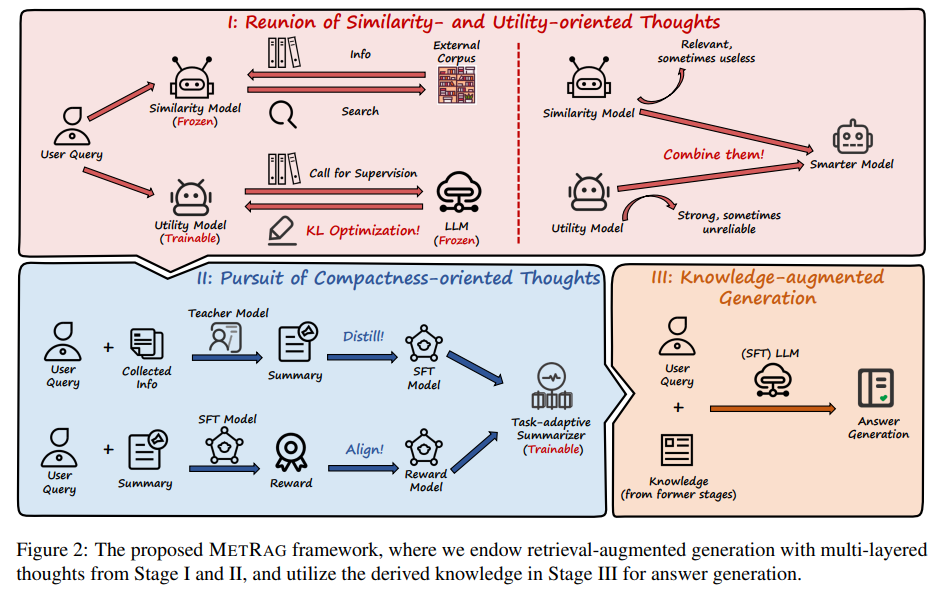

如图所示为METRAG的框架示意。

首先，METRAG 认为只靠相似性来检索文档不是最好的办法，还需要考虑文档对回答问题的有用性。就像你问“乔治·R·R·马丁是谁”，如果只根据相似性检索，可能会把一些不太有用的文档排在前面。所以 METRAG 引入了一个小的效用模型，它能从语言模型（LLM）那里获得监督，让模型知道哪些文档更有用。然后，METRAG 把相似性和效用结合起来，就像找一个既聪明又可靠的人来帮你做事一样。

其次，因为检索到的文档可能很多，直接把它们都给 LLM 用可能会让 LLM 感到困惑。所以 METRAG 提出了一个任务自适应的摘要器，它能把文档中的重要信息提取出来，让 LLM 更容易理解。就像你给别人讲一个故事，你会先把故事的主要内容概括一下，再讲给别人听。

最后，有了前面的这些准备，METRAG 就可以让 LLM 来生成答案了。LLM 会根据问题和检索到的知识来生成答案，就像你根据自己的知识和经验来回答问题一样。

总的来说，METRAG 通过给 RAG 赋予多层思维，让它能更好地理解问题和检索到的文档，从而生成更准确、更有用的答案。

## 七、大模型RAT

随着大型语言模型（LLMs）在自然语言处理（NLP）领域迅猛崛起，其处理多步推理和长期生成任务的能力日益受到瞩目。然而，这些尖端模型在应对复杂任务时，有时会遭遇“幻觉”现象，即产生不准确或误导性的信息。为了克服这一难题，增强模型的推理和生成质量，减少“幻觉”的产生，研究者们提出了一项创新性的策略——检索增强思维（Retrieval-Augmented Thoughts，简称RAT）。在本文中，我们将围绕动机、方法论、实验结果、创新性及局限性等关键维度，对RAT方法进行全面而深入的剖析。

### 动机背景

大型语言模型在处理多步推理任务时，如代码生成、数学推理等，需要依据上下文信息进行准确推理。然而，由于缺乏对真实世界知识的直接访问，模型可能会生成与事实不符的中间推理步骤，导致最终结果的不准确。为了解决这一问题，研究者们希望结合信息检索技术，通过检索与任务相关的信息来辅助模型进行更准确的推理。

### 方法详解
RAT方法将RAG与COT进行结合，RAG通过从可信源中提取和提问相关的文本来辅助模型生成答案，而COT则鼓励模型分布输出输理过程。

#### 1.RAG与COT概念回顾

检索增强生成（Retrieval-Augmented Generation，简称RAG）将信息检索（IR）与生成模型巧妙地结合，旨在提升文本生成的准确性和丰富性。RAG的核心思想在于，通过检索外部知识库中的相关信息，为语言模型提供有价值的辅助，以生成更加精确和丰富文本内容。

工作流程：

- 检索阶段：当接收到一个查询（如问题或任务提示）时，RAG首先会在一个预先构建且内容丰富的知识，寻找与查询最相关的文档。
- 生成阶段：一旦检索到相关文档，这些文档将作为生成模型的上下文输入。模型会基于这些真实、可靠的信息，生成相回答或续写文本。

<div class="alert alert-success">

关键优势：

- 减少幻觉：RAG通过引入真实可靠的信息，显著降低了模型生成虚假事实或误导性内容的可能性（这种现象在生成模型中通常被称为“幻觉”）。
- 增强上下文感知：通过检索外部知识库，RAG赋予了模型更强大的上下文感知能力。这使得模型能够生成更加符合逻辑、与上下文紧密相关的回答，提高了文本生成的整体质量。
</div>

链式思考（Chain of Thought，简称CoT）提示是一种创新的方法，旨在引导语言模型（LM）在解决复杂问题时展现出逐步推理的能力。这种方法模拟了人类在处理问题时所采用的逐步思考和推理的过程。以下是CoT的工作原理及其关键优势：

工作原理：

- 分步推理：当面临一个复杂问题时，语言模型不是直接给出答案，而是首先生成一个或多个中间推理步骤，即所谓的“思考链”。
- 逐步生成：基于当前的推理步骤，模型会逐步构建并生成下一个推理步骤，以此类推，直至得出最终答案。

<div class="alert alert-success">

关键优势：

- 增强推理能力：通过显式地生成推理步骤，CoT提示显著增强了语言模型的推理能力，使其能够更好地理解和解决问题。
- 提高答案质量：由于CoT提示要求模型逐步推理并生成答案，因此生成的答案通常更准确、更可解释。这种方法有助于减少错误和误解，提高答案的可靠性和有效性。
</div>

#### 2.RAG与COT的结合
RAT的核心思想是使用RAG迭代地修正由CoT提示生成的每一步思考。RAT方法将RAG和CoT提示结合起来,以解决长期生成任务中的挑战。RAT的工作流程如下:

- 零样本CoT生成：根据任务提示，LLM零样本生成一步步的思考(CoTs)。
- 检索与修正：将任务提示和已生成的CoTs作为查询，检索相关信息，并用于修正当前思考步骤。
- 逐步生成与修正：按照CoT的顺序，逐步生成回应，并在每一步中根据检索到的信息修正当前的思考步骤。
- 最终回应生成：根据修正后的思考步骤，生成最终的回应。
RAT的优势包括:

- 结合了RAG和CoT的优点：RAT利用了RAG的信息检索能力和CoT的推理步骤生成能力。
- 上下文感知和事实准确性：RAT生成的回答更加上下文感知，并且减少了幻觉，提高了事实准确性。
RAT的挑战包括:

- 依赖外部知识库：RAT的性能受限于外部知识库的质量和相关性。
- 计算成本：迭代地修正每个推理步骤可能会增加计算成本。
通过这种结合，RAT方法在多步推理和长期生成任务中展现出了显著的性能提升，为大型语言模型的应用和发展提供了新的可能性。

### 实现过程
以下是RAT的伪代码

<img src="images/RAT-伪代码.png"  width="600"  />

RAT算法的流程可以细分为以下几个步骤：

**1.步骤0**：生成初始CoT

- 输入一个任务提示（Task Prompt）。
- LLM基于该提示进行零样本推理，生成初始的逐步思考（Initial CoTs）。

**2.步骤1-N**：迭代修正CoT的每个步骤

- 对于每个思考步骤Ti（其中i表示步骤的序号）：
- 使用当前草稿答案T*和任务提示生成查询Qi。
- 利用查询Qi从知识库（Library）中检索相关信息Ri。
- 基于检索到的信息Ri和草稿答案T*，LLM修正第i步的思考，生成修正后的思考T*i。

**3.步骤N+1**：生成最终回答

- 将所有修正后的思考步骤串联起来，形成最终的回答。



### 实验与样例分析

如果同时拥有OpenAI和Google的Key，可以自己试着将RAT的样例代码运行起来。https://github.com/CraftJarvis/RAT.git

作者在huggingface上提供了[demo](https://huggingface.co/spaces/jeasinema/RAT)系统（系统经常不稳定）

下面通过一个示例来说明RAT的过程（示例来自[原论文](https://arxiv.org/pdf/2403.05313)）


向ChatGPT询问美国历史

<img src="images/RAT-1.png"  width="600"  />

可以看出大模型回复的相对简单，第一段简要介绍了美国独立前的情况，第二段简要介绍了独立战争后到冷战的情况，最后一段一句话总结了现在的总体情况。总休上按时间顺利简单介绍，但显然，不能满足大多数人的需求。

当我们使用COT的方法时，模型的回复如下：

<img src="images/RAT-2.png"  width="600"  />

明显地，模型的回复分成了几个部分：前哥伦布时期，殖民时期，美国独立战争及之后，既更加详细，也使结构更加清晰。但略显生硬，更像是“查资料”不像“回答问题”。而当我们使用RAT后：

<img src="images/RAT-3.png"  width="600"  />

可以看出，最后这篇文章更加详实，对美国历史上重大的历史事件，都有涉及，且段落之间过度更加自然，以“讲述性”的方式，回答了向大模型提出的问题。

### 创新点

RAT的创新之处在于它融合了CoT提示和RAG方法，通过反复修正每一步思考，借助外部知识库来辅助模型进行更精确的推理。这种策略不仅提升了检索信息的关联性，还大幅增强了生成内容的准确性和可信度。

- 整合CoT与RAG：RAT创造性地将CoT的分步推理与RAG的信息检索相结合，开创了一种新颖的提示技术。
- 迭代改进：RAT通过逐个迭代改进每个思考步骤，而不是一次性修改整个CoT，从而提高了修正的精细度和回答生成的质量。

### 不足与展望
尽管RAT在众多任务中表现出色，但它并非没有缺陷。首先，RAT的功效在很大程度上取决于其底层LLM的CoT推理和RAG能力。如果基础模型在这些方面表现不佳，RAT的表现也可能受到影响。其次，RAT的性能还受到检索到的知识质量的制约。低质量或不相关的检索结果可能会对LLM生成信息的效用产生不利影响。此外，由于RAT需要通过多次迭代进行检索和修正，这可能会增加计算成本并导致响应延迟，尤其是在处理大型知识库时。最后，RAT采用的显式分步骤问题解决方法可能不适合所有类型的问题，有些问题可能需要更复杂的推理结构，例如树状或网络状推理。

## 八、扩展学习

### OpenAI Assistant API

OpenAI Assistant API 使开发者能够将先进的人工智能功能整合到他们的应用程序中。这个API基于最新的机器学习和自然语言处理技术，提供了文本生成、语言翻译、摘要和问答等多种功能。它能够处理复杂和微妙的人类语言，适用于客户服务、内容创作和数据分析等多个领域。API的灵活架构使其可以根据不同行业的特定用途进行定制。此外，API不断进行更新和改进，融入人工智能研究的最新进展。

Assistant API出现前有哪些问题：
- 无法预先学习客户提供的知识，比如我没办法让它读完一本新写的书，因为这本书不在它的知识库里；
- 没有连续对话支持，每次调用它的 API 都需要发送对话的全部上下文，而这个上下文是有长度限制的；
- 没有真正的推理和执行能力，在数学计算方面尤其明显，它很可能给你一个错误的计算结果，因为它并没有真正的执行计算；

<div class="alert alert-warning">
Asistant API的主要功能：

- Threading：提供持久保存且无限长度的上下文，开发人员可以不用关心上下文的存储了，而且更省钱
- Knowledge Retrieval：检索用户上传的文件内容，并在未来可能支持开发者自定义检索方式
- Code Interpreter：执行用户上传的脚本文件来解决问题，可以上传多个脚本，AI 自己会选择何时执行
- Function Calling：调用第三方函数，只需要告诉 AI 函数功能和请求格式，AI 自己会选择何时执行
</div>

<img src="images/杀死公司.png"  width="900" height="600" alt="UDAPDR"/>

<img src="images/杀死公司cn.png"  width="900" height="600" alt="UDAPDR"/>

### GPTs

<img src="images/GPTs.png"  width="600" height="600" alt="UDAPDR"/>

In [ ]:
# 下面使用中文回答，先不要着急进行定制化，先回答我几个问题
# 在我定制GPT的时候可以选择基于的模型型号以及对选择的模型进行微调吗

GPTs的定制化目前基于GPT-4模型，这意味着在当前阶段，构建GPTs时不提供选择不同底层模型的选项。换言之，GPTs的核心功能主要依赖于RAG（Retrieval-Augmented Generation，检索增强生成技术）和开放的插件系统，以实现agent的个性化定制。这样的设计允许用户充分利用GPT-4的高级能力，并通过结合RAG技术和多种插件，定制出满足其特定需求的智能代理。这种方法不仅使GPTs继承了GPT-4的尖端技术，还增加了更多的适应性和灵活性，以适应用户的多样化需求。

然而，这种方法也有其局限性。由于当前的GPTs不支持对底层模型进行微调，因此必须依赖RAG和插件来弥补这一点。这可能会带来一些问题，特别是在处理那些RAG可能不擅长的特定类型的查询和任务时。RAG系统虽然强大，但在某些情境下可能不如定制微调的模型那样精准或有效，特别是在需要高度专业化或定制化知识的场景中。因此，用户在使用GPTs进行定制时，需要考虑到这些潜在的限制，并相应地调整他们的期望和使用策略。

<img src="images/GPTs 限制.png"  width="900" height="600" alt="UDAPDR"/>

### GPT Store

1月10日，OpenAI的应用商店 GPT Store 正式上线，分类、趋势、每周精选等栏目一应俱全。正像大部分应用商店那样，GPT Store 包括流行下载的社区排行榜，用户可以按类别搜索，例如写作、生活方式和教育。

这其中出现了一批独居特色的GPT包括：

- 能够提供个性化旅行建议的 AllTrails
- 能够从 2 亿份学术论文中搜索和分析结果的 Consensus
- 可汗学院创建的能够帮你提高编码技能的 Code Tutor
- 能够辅助设计演示文稿或社交帖子的 Canva
- 能够帮助你找到一本书的 Books
- 能够随时随地帮助你学习数学和科学的 CK-12 Flexi AI

到目前为止，只有订阅 OpenAI 付费套餐的用户才能制作和使用自定义 GPT。这是 OpenAI 在 ChatGPT 庞大用户基础上所做的一次尝试。

<img src="images/GPT store.png"  width="900" height="600" alt="UDAPDR"/>

### RAGFlow

#### RAGFlow的简介
RAGFlow 是一个基于深度文档理解的开源 RAG（检索增强生成）引擎。它为任何规模的企业提供了简化的 RAG 工作流程，结合了 LLM（大型语言模型）以提供真实的问答功能，并由来自各种复杂格式数据的有根据的引用提供支持。

RAG 从提出至今，市面上已有许多RAG产品，然而在实际应用中，却普遍得出了“ RAG 属于上手容易，但真正落地却很难”的结论。一方面是国内能使用的大模型在摘要能力、可控性（又听话又不会有幻觉）、翻译能力同时表现较好的较少；另一方面在RAG系统本身的构建中，应对复杂多变的数据以及提高检索时的准确召回能力，也是难以完美解决的痛点。
<div class="alert alert-success">
    
基于RAG本身的痛点，RAGFlow试图解决多样化文档的处理问题，系统包括以下特点：<br>
- 它是一套基于 AI 模型的智能文档处理系统：对于用户上传的文档，它需要自动识别文档的布局，包括标题、段落、换行等，还包含难度很大的图片和表格。对于表格来说，不仅仅要识别出文档中存在表格，还会针对表格的布局做进一步识别，包括内部每一个单元格，多行文字是否需要合并成一个单元格等。并且表格的内容还会结合表头信息处理，确保以合适的形式送到数据库，从而完成 RAG 针对这些细节数字的“大海捞针”。<br>
- 它是一套包含各种不同模板的智能文档处理系统：不同行业不同岗位所用到的文档不同，行文格式不同，对文档查阅的需求也不同。<br>
- 智能文档处理的可视化和可解释性：用户上传的文档到底被处理成啥样了，如：分割了多少片，各种图表处理成啥样了，毕竟任何基于 AI 的系统只能保证大概率正确，作为系统有必要给出这样的空间让用户进行适当的干预，作为用户也有把控的需求，黑箱不敌白箱。特别是对于 PDF，行文多种多样，变化多端，而且广泛流行于各行各业，对于它的把控尤为重要，RAGFlow 不仅给出了处理结果，而且可以让用户查看文档解析结果并一次点击定位到原文，对比和原文的差异，可增可减可改可查。<br>
- RAGFlow 是一个完整的 RAG 系统，而目前开源的 RAG，大都忽视了 RAG 本身的最大优势之一：可以让 LLM 以可控的方式回答问题，或者换种说法：有理有据、消除幻觉。我们都知道，随着模型能力的不同，LLM 多少都会有概率会出现幻觉，在这种情况下， 一款 RAG 产品应该随时随地给用户以参考，让用户随时查看 LLM 是基于哪些原文来生成答案的，这需要同时生成原文的引用链接，并允许用户的鼠标 hover 上去即可调出原文的内容，甚至包含图表。如果还不能确定，再点一下便能定位到原文。<br>
</div>
#### RAGFlow的搭建

RAGFlow 系统是一个高效、智能的信息处理平台，它通过一系列精心设计的组件，实现了对复杂查询的快速响应和精准处理。这个系统的核心组件包括：

- 文档解析器：这是 RAGFlow 系统的“大脑”，负责将各种格式的文档进行解析，从中提取出文本、图像和表格等关键内容。无论是PDF、Word文档还是Excel表格，文档解析器都能够准确捕捉信息，为后续的处理打下基础。

- 查询分析器：这个组件是 RAGFlow 系统的“神经系统”，它对用户的查询进行深入分析，识别并提取出查询中的关键信息。通过这种分析，系统能够更准确地理解用户的需求，为检索工作提供精确的指导。

- 检索：这是 RAGFlow 系统的“搜索引擎”，它使用查询分析器提供的关键信息，从海量文档中快速检索出与之相关的信息。检索组件的强大能力保证了用户能够及时获得所需的数据。

- 重排：这个组件是 RAGFlow 系统的“过滤器”，它对检索到的信息进行排序和过滤，确保最终呈现给用户的信息是最相关、最有价值的。通过这种方式，系统能够去除冗余和不相关的数据，提高信息的准确性和可用性。

- LLM：作为 RAGFlow 系统的“语言生成器”，LLM（大型语言模型）负责将排序后的信息整合并生成最终的答案或输出。LLM的强大生成能力不仅能够确保答案的准确性，还能够使答案表达得更加自然和流畅。

<img src="images/RAGFlow-1.png"  width="800"  />

系统的工作流程可以概括为以下几个步骤：

- 首先，当用户输入一个查询时，查询分析器便开始工作。它对用户的查询进行深入分析，从中提取出关键信息，这些信息是后续检索工作的基础。
接下来，检索模块根据查询分析器提供的关键信息，在大量的文档资源中寻找与之相关的数据。这一步骤是在整个系统中非常关键的一环，因为它直接决定了后续答案的相关性和准确性。
- 然后，重排模块对检索到的信息进行进一步的排序和过滤。这一步骤确保了最终呈现给用户的信息是经过优化的，去除了不相关或冗余的内容，使得答案更加精确和有价值。
- 最后，LLM（大型语言模型）根据重排模块提供的信息，生成最终的答案或输出。LLM的强大生成能力使得答案不仅准确，而且表达流畅自然，就像一个知识丰富的助手在回答用户的问题一样。

#### RAGFlow服务搭建

RAGFlow开发者提供了搭建RAGFlow服务的[教程](https://github.com/infiniflow/ragflow/blob/main/docs/quickstart.md)
</div>
也可以在线使用其演示系统：https://demo.ragflow.io/

#### RAGFlow使用示例
<div class="alert alert-success">
我们在demo系统上上传了一篇论文，该论文是2024年1月发表在Neural Networks上的一篇文章，提出了一种名为(CadaFT) 的对抗域适应(adversarial domain adaptation)方法。
</div>

<img src="images/RAGFlow-2.png"  width="800"  />

我们创建了一个名为abc的知识库，而后上传了该论文，并使用系统完成了文档的处理，点击文档名，可以查看处理情况。

<img src="images/RAGFlow-3.png"  width="800"  />

表格也处理得不错

<img src="images/RAGFlow-4.png"  width="800"  />

而后，我们创建一个Assistant（Demo网站上只能使用DeepSeek的模型，自己部署的可以选择其他模型） ，并和它探讨有关问题。

<img src="images/RAGFlow-5.png" width="800"   />


## 课程小结

一、RAG的由来

二、RAG示例
- PDF
- 纯文本

三、RAG在大模型优化的位置

四、RAG各组件优化方案
- 检索器 Retriever
- 生成器 Generator

五、RAG 的优缺点


六、RAG系统常见的问题以及解决方案
- 常见问题
- 解决方案

七、大模型RAT
- 背景动机
- 方法详解

八、扩展学习
- Assistant API
- GPTs/GPT store
- RAGFlow